In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

In [3]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [4]:
customers = pd.read_excel('Dataset/Dataset.xlsx',
                          sheet_name=0,
                          header=0,
                          index_col=False,
                          keep_default_na=True)

In [5]:
df_raw = customers.copy()

In [6]:
df_test = pd.read_csv('Dataset/TestData.csv')

In [7]:
df_test.drop('FraudFound_P', inplace=True, axis=1)

In [8]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c,
            label=l,
            marker=m)
        
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 50): 
            display(df)

In [10]:
display_all(customers.head())

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21.0,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1.0,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,55526.069421
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4.0,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,59294.455571
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3.0,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,71756.941320
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2.0,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,7584.153493
4,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,36.0,Third Party,Sport - Collision,Sport,more than 69000,0,7,14,400,1.0,more than 30,more than 30,1,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision,98545.374339


In [11]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

In [12]:
train_cats(df_raw)

In [13]:
df_raw.Month.cat.set_categories(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                                ordered=True,
                                inplace=True)

In [14]:
df_raw.DayOfWeek.cat.set_categories(['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                    ordered=True,
                                    inplace=True)

In [15]:
df_raw.DayOfWeekClaimed.cat.set_categories(['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                           ordered=True,
                                           inplace=True)

In [16]:
df_raw.MonthClaimed.cat.set_categories(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                                       ordered=True,
                                       inplace=True)

In [17]:
apply_cats(df=df_test, trn=df_raw)

In [18]:
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [19]:
df, y, nas = proc_df(df_raw, 'FraudFound_P')
X_test, _, nas = proc_df(df_test, na_dict=nas)
df, y, nas = proc_df(df_raw, 'FraudFound_P', na_dict=nas)

In [20]:
display_all(df.head())

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize,Age_na,DriverRating_na
0,12,5,3,7,2,2,1,1,1,3,21.0,1,6,2,6,1,12,300,1.0,4,3,4,2,4,1,1,1,4,1,3,1994,3,55526.069421,False,False
1,1,3,3,7,2,1,1,4,2,3,34.0,1,5,2,6,2,15,400,4.0,4,3,4,5,5,2,1,1,4,4,1,1994,2,59294.455571,False,False
2,10,5,5,7,2,4,11,2,2,2,47.0,1,5,2,6,3,7,400,3.0,4,3,1,6,7,1,1,1,4,4,1,1994,2,71756.941320,False,False
3,6,2,6,18,1,5,7,1,2,2,65.0,2,3,2,1,4,4,400,2.0,4,3,1,7,8,2,1,1,3,4,1,1994,3,7584.153493,False,False
4,2,1,6,7,2,1,2,3,2,2,36.0,2,5,2,6,7,14,400,1.0,4,3,1,6,6,1,1,1,1,4,1,1994,2,98545.374339,False,False


In [21]:
def error(x, y):
    print(confusion_matrix(x, y))
    print(f1_score(x, y))
    print(classification_report(x, y))
    
def print_score(m):
    result = [error(m.predict(X_train), y_train),
              error(m.predict(X_valid), y_valid),
              m.score(X_train, y_train),
              m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): result.append(m.oob_score_)

In [22]:
m = RandomForestClassifier()

m.fit(df, y)

m.score(df, y)

0.9998270644185041

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, random_state=0, test_size=0.15)

In [24]:
X_train.shape, X_valid.shape

((9830, 35), (1735, 35))

In [25]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_train, y_train)

print_score(m)

[[9198   95]
 [  41  496]]
0.8794326241134752
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9293
           1       0.84      0.92      0.88       537

    accuracy                           0.99      9830
   macro avg       0.92      0.96      0.94      9830
weighted avg       0.99      0.99      0.99      9830

[[1602   72]
 [  39   22]]
0.2838709677419355
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1674
           1       0.23      0.36      0.28        61

    accuracy                           0.94      1735
   macro avg       0.61      0.66      0.63      1735
weighted avg       0.95      0.94      0.94      1735



In [26]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
15,PolicyNumber,0.148358
32,ClaimSize,0.089452
10,Age,0.069119
0,Month,0.063691
6,MonthClaimed,0.060446
16,RepNumber,0.051062
3,Make,0.046932
22,AgeOfVehicle,0.037016
5,DayOfWeekClaimed,0.036451
2,DayOfWeek,0.036107


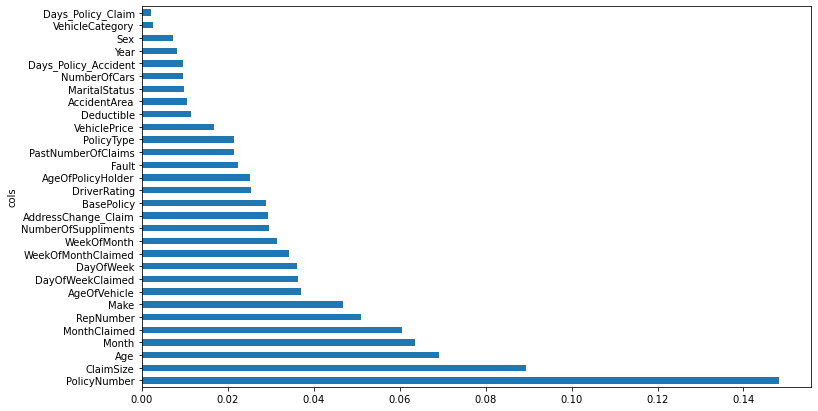

In [27]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [28]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_train.drop('PolicyNumber', axis=1), y_train)

result = [error(m.predict(X_train.drop('PolicyNumber', axis=1)), y_train),
          error(m.predict(X_valid.drop('PolicyNumber', axis=1)), y_valid),
          m.score(X_train.drop('PolicyNumber', axis=1), y_train),
          m.score(X_valid.drop('PolicyNumber', axis=1), y_valid)]

print(result)

[[9194  126]
 [  45  465]]
0.8446866485013624
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9320
           1       0.79      0.91      0.84       510

    accuracy                           0.98      9830
   macro avg       0.89      0.95      0.92      9830
weighted avg       0.98      0.98      0.98      9830

[[1577   84]
 [  64   10]]
0.11904761904761907
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1661
           1       0.11      0.14      0.12        74

    accuracy                           0.91      1735
   macro avg       0.53      0.54      0.54      1735
weighted avg       0.92      0.91      0.92      1735

[None, None, 0.9826042726347914, 0.9146974063400576]


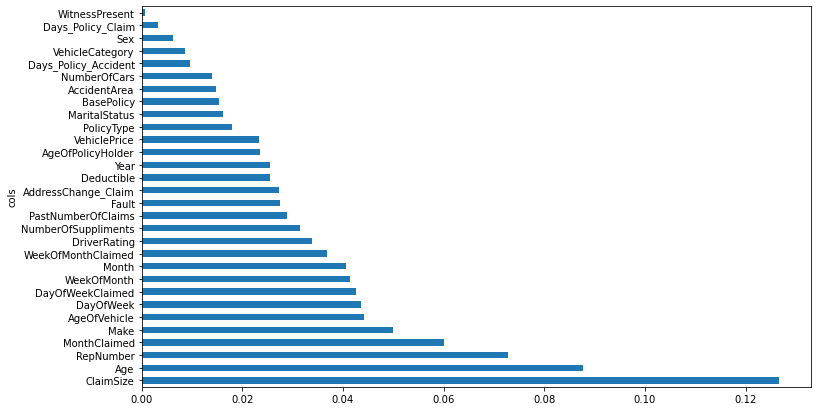

In [29]:
fi = rf_feat_importance(m, df.drop('PolicyNumber', axis=1))
plot_fi(fi[:30]);

In [30]:
m = RandomForestClassifier(n_estimators=1, n_jobs=-1, max_depth=3)

m.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=1, n_jobs=-1)

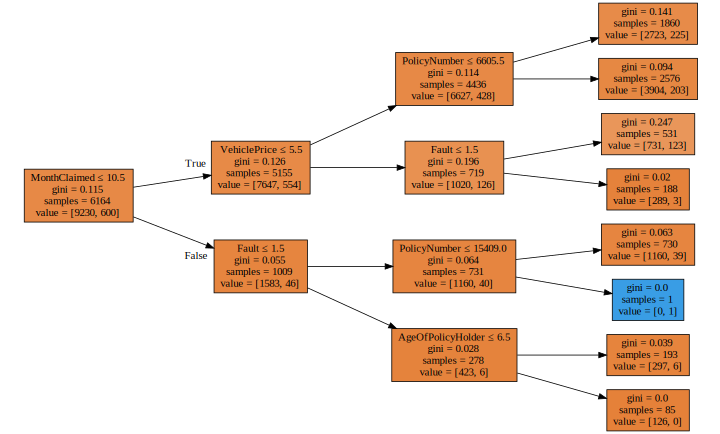

In [31]:
draw_tree(m.estimators_[0], X_valid, precision=3)

In [32]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
import lightgbm as lgb

print("LightGBM Version: {}".format(lgb.__version__))

Solving environment: done

# All requested packages already installed.

LightGBM Version: 3.2.1


In [34]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy={0: 6650}, n_jobs=-1)

X_cc_full, y_cc_full = cc.fit_resample(df, y)

plot_2d_space(X_cc_full, y_cc_full, 'Cluster Centroids Under-Sampling')

/Users/aniket/opt/anaconda3/lib/python3.8/site-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:120: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(


TypeError: '(array([ True,  True,  True, ..., False, False, False]), 0)' is an invalid key

In [35]:
lgb_train = lgb.Dataset(X_cc_full, y_cc_full, free_raw_data=False)

In [36]:
parameters = {'num_leaves': 2**5,
              'learning_rate': 0.05,
              'is_unbalance': True,
              'min_split_gain': 0.03,
              'min_child_weight': 1,
              'reg_lambda': 1,
              'subsample': 1,
              'objective':'binary',
              #'device': 'gpu', #Comment this line if you are not using GPU
              'task': 'train'}

num_rounds = 500

In [49]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

[LightGBM] [Info] Number of positive: 685, number of negative: 6650
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 7335, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093388 -> initscore=-2.272953
[LightGBM] [Info] Start training from score -2.272953
CPU times: user 4.99 s, sys: 897 ms, total: 5.88 s
Wall time: 942 ms


In [38]:
#With Policy Number
y_prob = clf.predict(X_valid)

y_pred = np.array([0 if i<0.45 else 1 for i in y_prob])

error(y_pred, y_valid)

[[1492    0]
 [ 149   94]]
0.5578635014836796
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1492
           1       1.00      0.39      0.56       243

    accuracy                           0.91      1735
   macro avg       0.95      0.69      0.76      1735
weighted avg       0.92      0.91      0.90      1735



In [39]:
y_prob = clf.predict(X_test)

y_pred_test = np.array([0 if i<0.45 else 1 for i in y_prob])

In [40]:
y_pred_df = pd.DataFrame(y_pred_test.reshape(-1, 1))

In [41]:
y_pred_df.columns = ['FraudFound_P']

In [42]:
y_pred_df.to_csv('test_results.csv', index=False)

In [51]:
lgb_train = lgb.Dataset(X_cc_full.drop('PolicyNumber', axis=1), y_cc_full, free_raw_data=False)

UsageError: Line magic function `%%time` not found.


In [52]:
%%time
clf = lgb.train(parameters, lgb_train, num_boost_round=num_rounds)

[LightGBM] [Info] Number of positive: 685, number of negative: 6650
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 7335, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093388 -> initscore=-2.272953
[LightGBM] [Info] Start training from score -2.272953
CPU times: user 3.64 s, sys: 269 ms, total: 3.9 s
Wall time: 540 ms


In [53]:
#No Policy Number
print(X_valid.shape)
y_prob = clf.predict(X_valid.drop('PolicyNumber', axis=1))

y_pred = np.array([0 if i<0.5 else 1 for i in y_prob])

error(y_pred, y_valid)

(1735, 35)
[[1381    0]
 [ 260   94]]
0.41964285714285715
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1381
           1       1.00      0.27      0.42       354

    accuracy                           0.85      1735
   macro avg       0.92      0.63      0.67      1735
weighted avg       0.87      0.85      0.81      1735



In [54]:
def gbm_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importance()}).sort_values('imp', ascending=False)

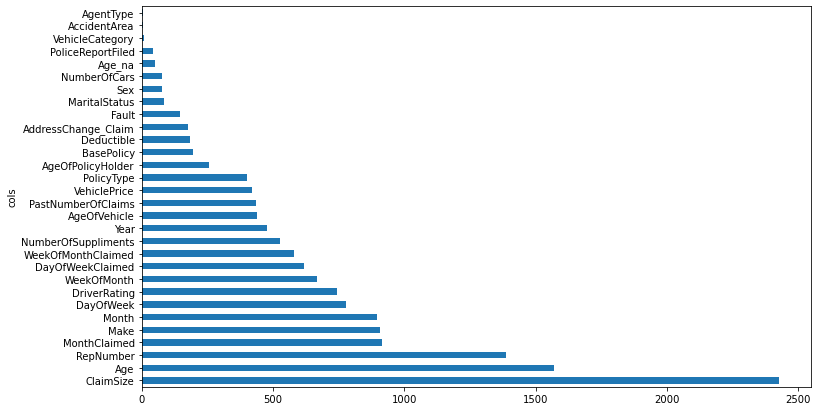

In [55]:
#Without using Policy Number
fi = gbm_feat_importance(clf, df.drop('PolicyNumber', axis=1))
plot_fi(fi[:30]);

In [59]:
(df_raw[(df_raw['FraudFound_P'] == 1) & (df_raw['Month'] == 'Dec')] ).shape
(df_raw[(df_raw['FraudFound_P'] == 0) & (df_raw['Month'] == 'Dec')] ).shape

(925, 34)

<AxesSubplot:>

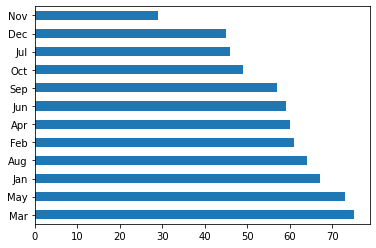

In [60]:
df_raw['Month'][df_raw['FraudFound_P'] == 1].value_counts().plot(kind='barh')

In [61]:
df_raw['RepNumber'].value_counts()

7     800
9     760
1     754
16    739
3     733
5     729
15    729
10    728
2     714
14    713
12    708
6     703
11    697
4     696
8     681
13    681
Name: RepNumber, dtype: int64

In [62]:
(df_raw['ClaimSize'][df_raw['FraudFound_P'] == 0]).value_counts()

98545.374339    20
69101.981954    19
77167.223246    18
58488.924392    18
85555.916236    18
                ..
14887.379776     1
19388.480868     1
20994.079097     1
18225.561061     1
3127.750681      1
Name: ClaimSize, Length: 3294, dtype: int64

In [ ]:
!conda install --yes --prefix {sys.prefix} -c conda-forge xgboost
from xgboost import XGBClassifier

m = XGBClassifier(n_estimators=800, n_jobs=4, base_score=0.3, max_depth=6)

m.fit(X_cc, y_cc)

In [ ]:
error(m.predict(X_valid.as_matrix()), y_valid)

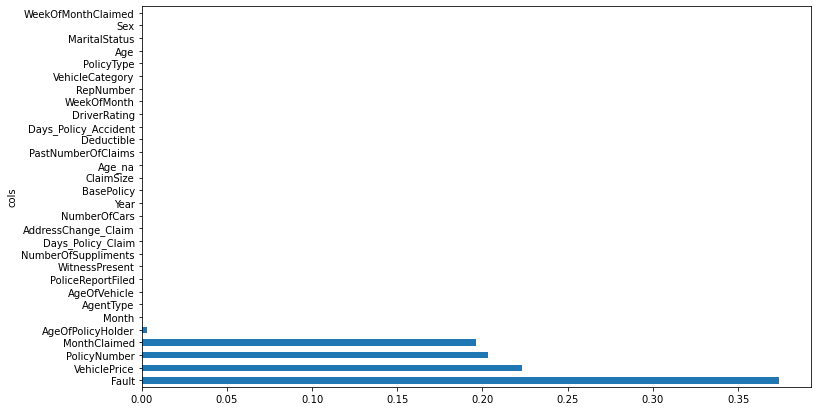

In [64]:
fi = rf_feat_importance(m, df)
plot_fi(fi[:30]);

In [65]:
import seaborn as sns

/Users/aniket/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


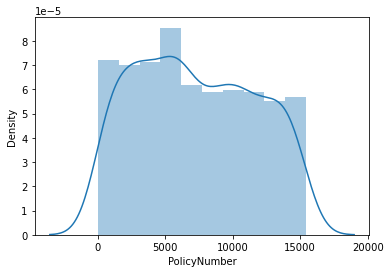

In [66]:
fraud = customers.loc[customers["FraudFound_P"]==1]
normal = customers.loc[customers["FraudFound_P"]==0]
sns.distplot(fraud.PolicyNumber)
plt.show()

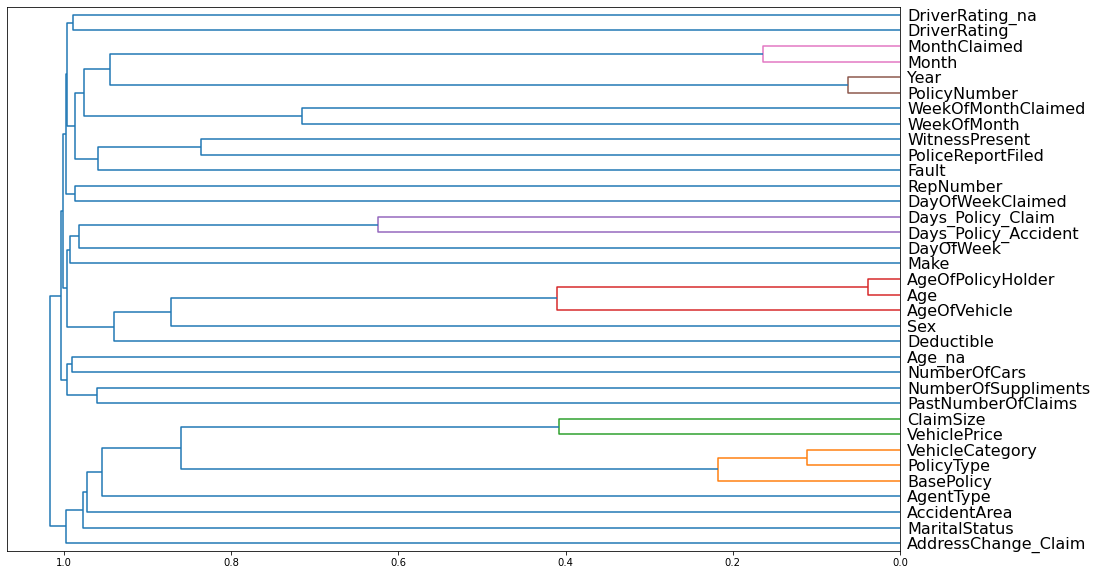

In [68]:
from scipy.cluster import hierarchy as hc

correlation = np.round(scipy.stats.spearmanr(df).correlation, 4)
correlation_condensed = hc.distance.squareform(1-correlation)
z = hc.linkage(correlation_condensed, method='average')
fig = plt.figure(figsize=(16, 10))

dendrogram = hc.dendrogram(z, labels=df.columns,
                           orientation='left',
                           leaf_font_size=16)

plt.show() 

In [69]:
from sklearn.svm import OneClassSVM

m = OneClassSVM(gamma='scale', degree=3, kernel='rbf')

m.fit(X_train)

y_prob = m.predict(X_valid)

y_prob[y_prob==-1].sum()

y_pred = np.array([0 if i==-1 else 1 for i in y_prob])

error(y_pred, y_valid)

[[808  55]
 [833  39]]
0.08074534161490685
              precision    recall  f1-score   support

           0       0.49      0.94      0.65       863
           1       0.41      0.04      0.08       872

    accuracy                           0.49      1735
   macro avg       0.45      0.49      0.36      1735
weighted avg       0.45      0.49      0.36      1735



In [70]:
m = IsolationForest(n_jobs=-1, n_estimators=100, max_features=0.5, bootstrap=True)

m.fit(X_train)

y_prob = m.predict(X_valid)

y_prob[y_prob==1].sum()

y_pred = np.array([1 if i==-1 else 0 for i in y_prob])

error(y_pred, y_valid)

[[1302   69]
 [ 339   25]]
0.10917030567685591
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1371
           1       0.27      0.07      0.11       364

    accuracy                           0.76      1735
   macro avg       0.53      0.51      0.49      1735
weighted avg       0.68      0.76      0.71      1735



In [71]:
from sklearn.neighbors import LocalOutlierFactor

m = LocalOutlierFactor(novelty=True, n_neighbors=30, algorithm='ball_tree', leaf_size=40, p=5)

m.fit(X_train)

y_prob = m.predict(X_valid)

y_pred = np.array([1 if i==-1 else 0 for i in y_prob])

error(y_pred, y_valid)

[[1632   93]
 [   9    1]]
0.01923076923076923
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1725
           1       0.01      0.10      0.02        10

    accuracy                           0.94      1735
   macro avg       0.50      0.52      0.49      1735
weighted avg       0.99      0.94      0.96      1735



In [72]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

In [73]:
rus = RandomOverSampler(random_state=42)

X_res, y_res = rus.fit_resample(X_train, y_train)

y_res[y_res == 1].sum()

9239

In [74]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_res, y_res)

print_score(m)

[[9193    0]
 [  46  591]]
0.9625407166123778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9193
           1       1.00      0.93      0.96       637

    accuracy                           1.00      9830
   macro avg       1.00      0.96      0.98      9830
weighted avg       1.00      1.00      1.00      9830

[[1582   68]
 [  59   26]]
0.29050279329608936
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1650
           1       0.28      0.31      0.29        85

    accuracy                           0.93      1735
   macro avg       0.62      0.63      0.63      1735
weighted avg       0.93      0.93      0.93      1735



In [ ]:
tl = TomekLinks(sampling_strategy='majority')

X_tl, y_tl, id_tl = tl.fit_resample(X_train, y_train)

print('Removed indexes:', id_tl.shape)

plot_2d_space(X_tl, y_tl, 'Tomek Links Under-Sampling')

In [ ]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_tl, y_tl)

print_score(m)

In [ ]:
cc = ClusterCentroids(sampling_strategy={0: 6000}, n_jobs=-1)

X_cc, y_cc = cc.fit_resample(X_train, y_train)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

In [ ]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_cc, y_cc)

print_score(m)

In [ ]:
cc = ClusterCentroids(sampling_strategy={0: 6000}, n_jobs=4)

X_cc, y_cc = cc.fit_resample(X_train.drop('PolicyNumber', axis=1), y_train)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

In [ ]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_cc, y_cc)

print_score(m)

In [ ]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_cc_full, y_cc_full)

print_score(m)

In [ ]:
smote = SMOTE(sampling_strategy='minority')

X_sm, y_sm = smote.fit_resample(X_train, y_train)

plot_2d_space(X_sm, y_sm, 'SMOTE Over-Sampling')

In [ ]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_sm, y_sm)

print_score(m)

In [ ]:
smt = SMOTETomek(sampling_strategy='auto')

X_smt, y_smt = smt.fit_resample(X_train, y_train)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek Links')

In [ ]:
(y_smt[y_smt == 1]).shape

In [ ]:
m = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=0.5)

m.fit(X_smt, y_smt)

print_score(m)